In [33]:
import pandas as pd
train= pd.read_csv('korean-hate-speech/labeled/train.tsv' ,sep='\t')
dev= pd.read_csv('korean-hate-speech/labeled/dev.tsv' ,sep='\t')

In [34]:
train

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate
...,...,...,...,...
7891,힘내세요~ 응원합니다!!,False,none,none
7892,힘내세요~~삼가 고인의 명복을 빕니다..,False,none,none
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,False,none,none
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,False,none,none


# 독립변수 처리

In [35]:
train = train[['comments','hate']]
train['hate'] = train['hate'].map({'none':0,'offensive':1,'hate':2})
dev = dev[['comments','hate']]
dev['hate'] = dev['hate'].map({'none':0,'offensive':1,'hate':2})

<ipython-input-35-4a9ecf198709>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['hate'] = train['hate'].map({'none':0,'offensive':1,'hate':2})


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(dev))

훈련용 리뷰의 개수 : 7896
테스트용 리뷰의 개수 : 471


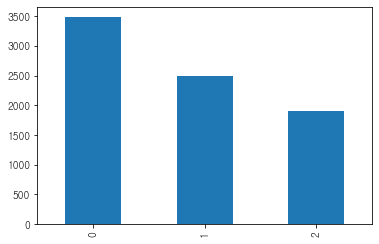

In [38]:
train['hate'].value_counts().plot(kind = 'bar')

# 불용어 제거 후 토큰화 작업

- ( , ) 도 추가
- ....은 의미 있을 수도 있어 제거 X

In [39]:
stopwords = ['(',')','도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '음', '면']

In [40]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

train['tokenized'] = train['comments'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
dev['tokenized'] = dev['comments'].apply(mecab.morphs)
dev['tokenized'] = dev['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

<ipython-input-40-2317ec7bde5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tokenized'] = train['comments'].apply(mecab.morphs)
<ipython-input-40-2317ec7bde5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [83]:
train_data, test_data = train_test_split(train, test_size = 0.25, random_state = 42)

# 단어 및 길이 분포 확인

In [84]:
from tensorflow.keras.utils import to_categorical
dataset_y = to_categorical(train_data['hate'])
dataset_y = np.array(dataset_y, dtype=np.int32)
print(dataset_y)

[[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [0 1 0]]


In [85]:
test_y = to_categorical(test_data['hate'])
test_y = np.array(test_y, dtype=np.int32)
print(test_y)

[[0 0 1]
 [1 0 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [86]:
X_train = train_data['tokenized'].values
y_train = dataset_y
X_test= test_data['tokenized'].values
y_test = test_y

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5922,), (5922, 3), (1974,), (1974, 3))

# 정수 인코딩

In [87]:
all_token = train['tokenized'].sum()

In [88]:
import nltk
text = nltk.Text(all_token, name='NMSC')

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            
seq_len = len(set(text.tokens))
# 출현 빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(200))

123281
13784
[('.', 6170), ('?', 1998), ('거', 1182), ('..', 999), ('나', 940), ('있', 918), ('안', 906), ('보', 898), ('ㅋㅋ', 779), ('아', 707), ('없', 695), ('는데', 681), ('잘', 672), ('좋', 667), ('냐', 660), ('ㅋㅋㅋ', 645), ('!', 618), ('어', 606), ('같', 591), ('겠', 585), ('여자', 574), (',', 572), ('사람', 559), ('로', 532), ('아니', 532), ('왜', 520), ('니', 510), ('되', 494), ('했', 482), ('것', 473), ('으로', 468), ('해', 458), ('기', 457), ('좀', 451), ('말', 446), ('에서', 437), ('너무', 410), ('진짜', 405), ('~', 405), ('주', 381), ('야', 373), ('라', 370), ('었', 364), ('남자', 340), ('뭐', 331), ('못', 329), ('할', 329), ('살', 325), ('애', 313), ('더', 305), ('많', 297), ('세요', 291), ('않', 287), ('서', 286), ('때', 286), ('시', 285), ('네요', 279), ('으면', 277), ('적', 267), ('일', 265), ('씨', 262), ('알', 258), ('건', 256), ('그', 255), ('았', 251), ('연기', 250), ('수', 248), ('인데', 246), ('나오', 246), ('자', 245), ('지만', 241), ('그냥', 241), ('라고', 240), ('결혼', 240), ('내', 236), ('돈', 228), ('까지', 228), ('기사', 227), ('싶', 223), ('랑', 219)

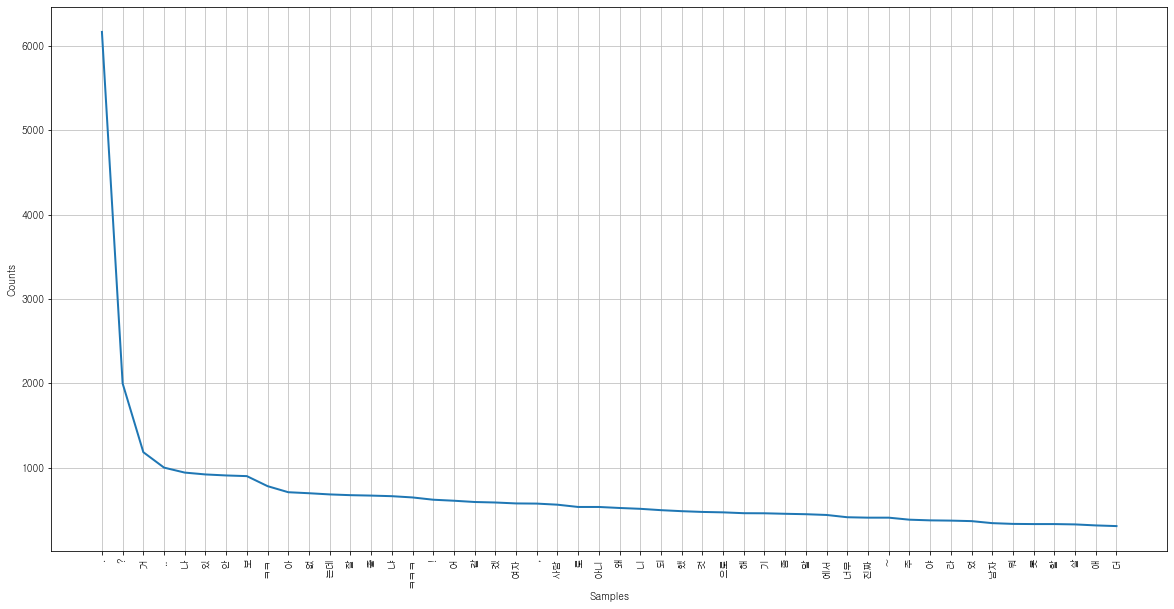

In [89]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

### 상위 빈도 seq_len만큼 벡터화

In [90]:
selected_words = [f[0] for f in text.vocab().most_common(seq_len)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(token) for token in X_train]
test_x = [term_frequency(token) for token in X_test]

In [91]:
#모델링을 하기 위해 리스트로 되어 있는 데이터 형식을 array로 바꿔주고 dtype도 실수로 바꿈
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [1]:
def test_modelling(x_train, y_train, x_test, y_test):
    global model
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras import losses
    from tensorflow.keras import metrics
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    from tensorflow.keras.models import load_model
    from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, BatchNormalization
    import tensorflow as tf
    # 모델 구조 정의하기
    input = tf.keras.layers.Input(shape=(54,))
    net = tf.keras.layers.Embedding(input_dim=seq_len, output_dim=32)(input) 
    net = tf.keras.layers.LSTM(units=32, return_sequences=True, activation='relu')(net) 
    net = tf.keras.layers.LSTM(units=32, activation='relu')(net) 
    net = tf.keras.layers.Dense(units=1, activation='sigmoid')(net)
    model.add(Dropout(0.3))
    model.add(layers.Dense(3, activation='softmax'))
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    history = model.fit(x_train, y_train, epochs=100, callbacks=[es,mc], batch_size=64, validation_split=0.2)
    loaded_model = load_model('best_model.h5')
    print("테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

In [2]:
test_modelling(x_train, y_train, x_test, y_test)

NameError: name 'x_train' is not defined

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11893
등장 빈도가 1번 이하인 희귀 단어의 수: 6259
단어 집합에서 희귀 단어의 비율: 52.62759606491213
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.743231450457341


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5636


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 패딩

리뷰의 최대 길이 : 61
리뷰의 평균 길이 : 15.673590003377237


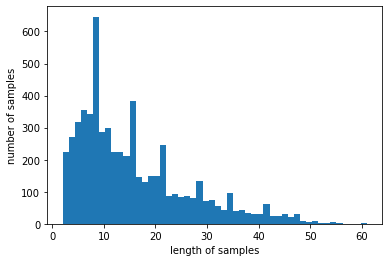

In [26]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [28]:
max_len = 61
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 61 이하인 샘플의 비율: 100.0


In [29]:
X_train

[[185, 607, 1775, 67, 6, 248],
 [2036,
  55,
  33,
  106,
  576,
  756,
  787,
  2,
  272,
  2037,
  1776,
  211,
  55,
  576,
  693,
  2,
  90,
  639,
  1439,
  23,
  22],
 [7, 9, 34, 426, 136, 3],
 [273,
  199,
  1,
  3846,
  47,
  130,
  11,
  438,
  2,
  522,
  2933,
  204,
  1777,
  1778,
  26,
  73,
  1,
  122,
  2],
 [14, 62, 343, 12, 27, 694, 1, 1126, 7, 2934, 358, 2038, 290, 55, 290],
 [39,
  2406,
  79,
  64,
  82,
  1,
  2,
  169,
  163,
  82,
  40,
  414,
  205,
  577,
  92,
  921,
  144,
  1,
  608,
  19,
  2406,
  63,
  76,
  146,
  2,
  1,
  63,
  206,
  9,
  186,
  82,
  547,
  873,
  11,
  874],
 [733, 133, 51, 200, 199, 110, 19, 21, 12, 2, 5, 125, 1779, 16],
 [128, 3847, 129, 2407, 20, 2407, 129, 3848],
 [1,
  1563,
  640,
  11,
  1780,
  3849,
  80,
  8,
  29,
  28,
  1127,
  1046,
  6,
  2039,
  2408,
  4,
  26,
  16,
  212,
  979,
  1047,
  2040,
  1048,
  480,
  1,
  354,
  317,
  507,
  1,
  140,
  383,
  32,
  234,
  36,
  44,
  42,
  18],
 [1, 1],
 [128,
  108,

In [30]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# normalization

In [31]:
X_train

array([[   0,    0,    0, ...,   67,    6,  248],
       [   0,    0,    0, ..., 1439,   23,   22],
       [   0,    0,    0, ...,  426,  136,    3],
       ...,
       [   0,    0,    0, ...,  136,   77, 2806],
       [   0,    0,    0, ...,  212,    2,  212],
       [   0,    0,    0, ...,  239,    1,   10]])

In [32]:
X_train[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  273,  199,
          1, 3846,   47,  130,   11,  438,    2,  522, 2933,  204, 1777,
       1778,   26,   73,    1,  122,    2])

In [33]:
train_list = []
for i, val in enumerate(X_train):
    train_list.append(list((val-np.mean(val)) / (np.max(val)-np.min(val))))

# 모델 구축

In [52]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))


### 1-D CNN

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model = Sequential()
model.add(Embedding(vocab_size, 256))
model.add(Dropout(0.3))
model.add(Conv1D(256, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [56]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(np.array(train_list), y_train, epochs=100, callbacks=[mc], batch_size=64, validation_split=0.2)

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.0745 - acc: 0.4433
Epoch 00001: val_acc improved from -inf to 0.43713, saving model to best_model.h5
75/75 [==============================] - 5s 61ms/step - loss: 1.0745 - acc: 0.4433 - val_loss: 1.0737 - val_acc: 0.4371
Epoch 2/100
74/75 [============================>.] - ETA: 0s - loss: 1.0708 - acc: 0.4470
Epoch 00002: val_acc did not improve from 0.43713
75/75 [==============================] - 6s 80ms/step - loss: 1.0708 - acc: 0.4469 - val_loss: 1.0788 - val_acc: 0.4371
Epoch 3/100
74/75 [============================>.] - ETA: 0s - loss: 1.0684 - acc: 0.4470
Epoch 00003: val_acc did not improve from 0.43713
75/75 [==============================] - 5s 73ms/step - loss: 1.0683 - acc: 0.4471 - val_loss: 1.0725 - val_acc: 0.4371
Epoch 4/100
74/75 [============================>.] - ETA: 0s - loss: 1.0696 - acc: 0.4468
Epoch 00004: val_acc did not improve from 0.43713
75/75 [==============================] - 4s 56ms

Epoch 32/100
74/75 [============================>.] - ETA: 0s - loss: 1.0671 - acc: 0.4468- ETA: 1s - loss:
Epoch 00032: val_acc did not improve from 0.43713
75/75 [==============================] - 6s 74ms/step - loss: 1.0670 - acc: 0.4469 - val_loss: 1.0700 - val_acc: 0.4371
Epoch 33/100
74/75 [============================>.] - ETA: 0s - loss: 1.0670 - acc: 0.4468
Epoch 00033: val_acc did not improve from 0.43713
75/75 [==============================] - 5s 73ms/step - loss: 1.0669 - acc: 0.4469 - val_loss: 1.0702 - val_acc: 0.4371
Epoch 34/100
74/75 [============================>.] - ETA: 0s - loss: 1.0665 - acc: 0.4470
Epoch 00034: val_acc did not improve from 0.43713
75/75 [==============================] - 4s 56ms/step - loss: 1.0665 - acc: 0.4469 - val_loss: 1.0701 - val_acc: 0.4371
Epoch 35/100
74/75 [============================>.] - ETA: 0s - loss: 1.0674 - acc: 0.4470
Epoch 00035: val_acc did not improve from 0.43713
75/75 [==============================] - 7s 90ms/step - los

74/75 [============================>.] - ETA: 0s - loss: 1.0668 - acc: 0.4468
Epoch 00094: val_acc did not improve from 0.43713
75/75 [==============================] - 7s 95ms/step - loss: 1.0667 - acc: 0.4469 - val_loss: 1.0701 - val_acc: 0.4371
Epoch 95/100
74/75 [============================>.] - ETA: 0s - loss: 1.0665 - acc: 0.4468
Epoch 00095: val_acc did not improve from 0.43713
75/75 [==============================] - 4s 58ms/step - loss: 1.0665 - acc: 0.4469 - val_loss: 1.0702 - val_acc: 0.4371
Epoch 96/100
74/75 [============================>.] - ETA: 0s - loss: 1.0665 - acc: 0.4470
Epoch 00096: val_acc did not improve from 0.43713
75/75 [==============================] - 6s 77ms/step - loss: 1.0665 - acc: 0.4469 - val_loss: 1.0702 - val_acc: 0.4371
Epoch 97/100
74/75 [============================>.] - ETA: 0s - loss: 1.0663 - acc: 0.4470- ETA: 0s - loss: 1.0655 - 
Epoch 00097: val_acc did not improve from 0.43713
75/75 [==============================] - 6s 78ms/step - loss: 

In [227]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

62/62 [==============================] - 1s 13ms/step - loss: 4.7960 - acc: 0.4311
테스트 정확도: 0.4311


In [106]:
preds = loaded_model.predict(X_test)
preds

array([[0.39774117, 0.4180528 , 0.18420602],
       [0.93720895, 0.05255724, 0.01023376],
       [0.53255975, 0.3266842 , 0.14075604],
       ...,
       [0.27636996, 0.466064  , 0.2575661 ],
       [0.2051393 , 0.4949639 , 0.29989678],
       [0.39454758, 0.3854387 , 0.22001368]], dtype=float32)

# 모델 평가 참고 

- https://ayoteralab.tistory.com/entry/Iris-dataset-classification-with-Keras?category=873956

In [29]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.show()

NameError: name 'history' is not defined

NameError: name 'dataset' is not defined

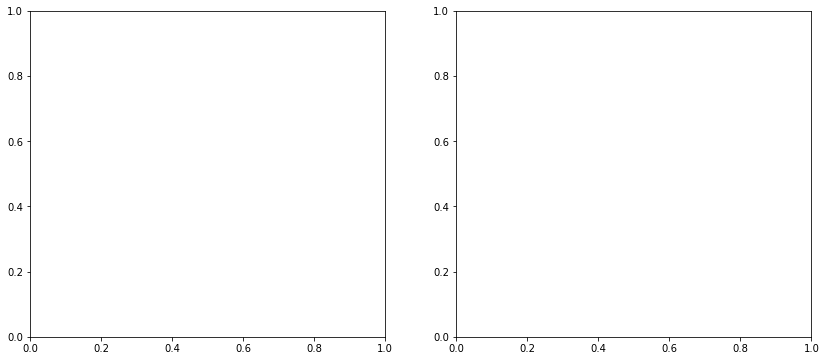

In [108]:
f, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].scatter(dataset.data[:,0], dataset.data[:,1], c=dataset.target)
ax[0].set_title('scatter with Sepal')
ax[1].scatter(dataset.data[:,2], dataset.data[:,3], c=dataset.target)
ax[1].set_title('scatter with Petal')
plt.show()